# Homework 5: Support Vector Machine and Tree-based Models

## Question 1: Build a perceptron model with numpy (60 pts)

In this question we ask you to implement a perceptron model to classify the `MNIST` digits 0 and 1 using the **numpy library only**. In our version of the perceptron model, we ignore the intercept (beta 0) coefficient for simplicity.

In [1]:
from keras.datasets import mnist
import numpy as np

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train[0:60000,:,:].reshape((60000, 28*28)) /255  # flatten the image for the convenient of downstream analysis
X_test = X_test[0:10000,:,:].reshape((10000, 28*28)) /255  # flatten the image for the convenient of downstream analysis

X_train = X_train[np.where((y_train==0) | (y_train==1))[0],:]
y_train = y_train[np.where((y_train==0) | (y_train==1))[0]]

X_test = X_test[np.where((y_test==0) | (y_test==1))[0],:]
y_test = y_test[np.where((y_test==0) | (y_test==1))[0]]

# recode 0 as -1
recode = {0: -1, 1: 1}
y_train_recoded = [recode[y] for y in y_train]
y_test_recoded = [recode[y] for y in y_test]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### 1.1  (40 pts)

In the following code block, fill out the lines with comments. Again, remember that we ignore the beta0 coefficient.

In [2]:
class PERCEPTRON:
    def __init__(self):
        self.weights = None

    def fit(self, X, y, epochs=10, learning_rate=1):
        self.weights = np.zeros(X.shape[1])    # Initiate weights with a vector of all zeros, length equals the number of features in X (5 pts)
        for epoch in range(epochs):
            print('Epoch ' + str(epoch) + ' finished.')
            for i in range(X.shape[0]):
                pred = np.dot(X[i], self.weights)    # Calculate the inner product of the i th row of X and the current weight vector (5 pts)
                if pred*y[i] <= 0:
                  self.weights += learning_rate * X[i] * y[i]    # Update the weights with value of the i th row of X scaled by the i th element of y, weighted by the learning_rate hyperparameter (10 pts)

    def predict(self, new_X):
        new_pred = np.dot(new_X, self.weights)    # Calculate the inner product(s) of the rows of new_X and the weight vector (10 pts)
        new_y = new_y = np.where(new_pred > 0, 1, -1)    # Make binary prediction, output a vector of -1 or 1 (10 pts)
        return new_y

### 1.2 (10 pts)

Instantiate an instance of the PERCEPTRON class, and fit it with X_train and y_train_recoded. Let's try 1 epoch with learning_rate=1. Obtained predicted classes of X_test. Build a confusion matrix to evaluate the performance on test data.

In [3]:
from sklearn.metrics import confusion_matrix

# instantiate the PERCEPTRON class
model = PERCEPTRON()

# fit the model on the training data for 1 epoch with a learning rate of 1
model.fit(X_train, y_train_recoded, epochs=1, learning_rate=1)

# obtain predicted classes for X_test
y_pred = model.predict(X_test)

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Epoch 0 finished.
Confusion Matrix:
[[   0    0    0]
 [ 979    0    1]
 [   3    0 1132]]


### 1.3 (10 pts)

Plot the weights of the trained perceptron model as a $28 \times 28$ image.

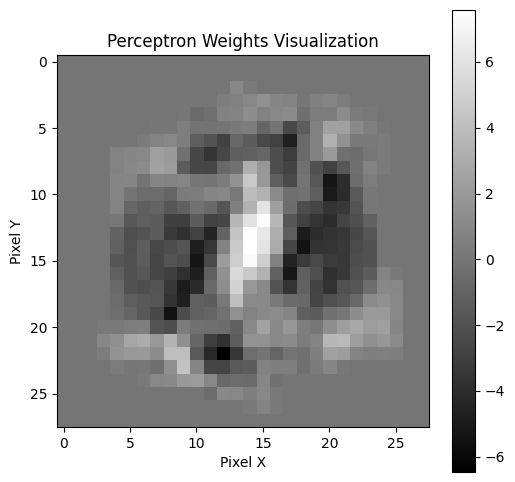

In [4]:
import matplotlib.pyplot as plt

# Reshape the weights vector into a 28x28 matrix
weights_image = model.weights.reshape(28, 28)

# Plot the weights as an image
plt.figure(figsize=(6, 6))
plt.imshow(weights_image, cmap='gray')
plt.colorbar()
plt.title("Perceptron Weights Visualization")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

## Question 2: Classification with Gradiant Boosting (40 pts)

For this question we are going to use the `CIFAR10` dataset.

Sample points in the CIFAR10 dataset are 50,000 images of $32 \times 32$  pixels, with three color channels (RGB). The feature space is 3072-dimensional. Let's try using a gradient boosting tree on this image classification task. To do that we have to flatten the pixels, and treat pixels as independent features.

In [5]:
from keras.datasets import cifar10
(train_set_images, train_set_labels), (test_set_images, test_set_labels) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [6]:
train_set_images.shape

(50000, 32, 32, 3)

Image in `cifar10` belong to 10 categories. In the data set the classes are numerically encoded. Information about the classes can be found here: https://www.cs.toronto.edu/~kriz/cifar.html
Let's visualize an example:

<ipython-input-7-96ca7ce1db98>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('class {}: {}'.format(int(train_set_labels[0]), classes[int(train_set_labels[0])]))


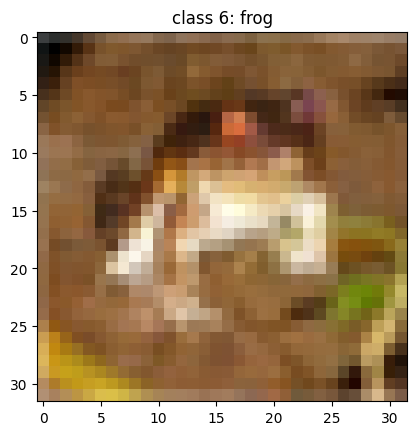

In [7]:
import matplotlib.pyplot as plt
classes = ['airplane', 'automobile','bird','cat','deer','dog', 'frog', 'horse','ship', 'truck']
im = train_set_images[0,:,:,:]
plt.imshow(im)
plt.title('class {}: {}'.format(int(train_set_labels[0]), classes[int(train_set_labels[0])]))
plt.show()

The python package `lightgbm` has a lot of convenient functionalities, and it works in a sklearn fashion (https://lightgbm.readthedocs.io/en/latest/Python-API.html). It is a very efficient algorithm, but it still takes a while to train the model on CIFAR10. Let's do a sub-problem of telling the difference between `cat` and `dog`.

### 2.1 (10 pts)

Subset the above training (n=50,000) and test (n=10,000) data splits, only keep images of cats and dogs.

In [8]:
import torch
from torchvision import datasets, transforms
import numpy as np

# define the labels for cats and dogs in CIFAR10
CAT_LABEL = 3
DOG_LABEL = 5

# define transformations (normalize if needed for modeling)
transform = transforms.Compose([
    transforms.ToTensor(),
])

# load CIFAR10 dataset
train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

# function to filter dataset by classes (cats and dogs only)
def filter_classes(dataset, classes=[CAT_LABEL, DOG_LABEL]):
    # find indices of samples that are cat and dog
    indices = [i for i, label in enumerate(dataset.targets) if label in classes]
    # subset data
    dataset.data = dataset.data[indices]
    dataset.targets = np.array(dataset.targets)[indices].tolist()
    return dataset

# filter train and test datasets to only include cats and dogs
train_data = filter_classes(train_data)
test_data = filter_classes(test_data)

# flatten images
train_data_flat = train_data.data.reshape(len(train_data.data), -1)
test_data_flat = test_data.data.reshape(len(test_data.data), -1)
print("Subset training data shape:", train_data_flat.shape)
print("Subset test data shape:", test_data_flat.shape)


100%|██████████| 170M/170M [00:03<00:00, 46.8MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Subset training data shape: (10000, 3072)
Subset test data shape: (2000, 3072)


### 2.2 (20 pts)

First, build a gradient boosting tree model with the default settings and calculate the AUC value on validation set.

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# prepare labels as binary (cats = 0, dogs = 1)
y_train = np.array([1 if label == DOG_LABEL else 0 for label in train_data.targets])

# split train_data_flat and y_train into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_data_flat, y_train, test_size=0.2, random_state=42)

# initialize and train the Gradient Boosting model with default settings
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

# get predicted probabilities for the positive class (dogs) on the validation set
y_val_probs = gb_model.predict_proba(X_val)[:, 1]

# calculate AUC
auc = roc_auc_score(y_val, y_val_probs)
print("AUC on validation set:", auc)

AUC on validation set: 0.7067093603842434


### 2.3 (10 pts)

Is this result satisfactory? If not, what could the problem be?

The AUC generated was not necessarily low but also not very high (~.71). A few reasons why this model was not the best fit for these images could be the fact that this data is highly dimensional and there could be hidden patterns within the data that this model was not able to capture. Lower AUC values can also be caused by class imbalances, not enough preprocessing/feature extraction, and using too general model parameters for this data.